# CNN

## Import data

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from scipy import stats

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, 
    Embedding, Concatenate, Dropout, BatchNormalization,
    GlobalAveragePooling1D, Bidirectional, LSTM
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import save_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, 
    f1_score, accuracy_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
# from kerastuner import RandomSearch
# from kerastuner.engine.hyperparameters import HyperParameters

In [166]:
df = pd.read_csv("Features_For_Traditional_ML_Techniques.csv", index_col=0)

In [167]:
numerical_features = [col for col in df.columns if col not in 
                      ['majority_target', 'statement', 'BinaryNumTarget', 'tweet', 'embeddings']]

In [168]:
tweets = df['tweet']
statements = df['statement']

In [169]:
df_tweets = pd.DataFrame(tweets)

In [170]:
df_tweets['tweet_length'] = df_tweets['tweet'].apply(lambda x: len(x.split()))
df_tweets['tweet_length_char'] = df['tweet'].apply(len)
max_length_words = df_tweets['tweet_length'].max()

In [171]:
max_length_words

108

(array([1.2668e+04, 4.3989e+04, 6.3464e+04, 1.3163e+04, 2.3700e+02,
        8.7000e+01, 4.8000e+01, 1.1400e+02, 1.8700e+02, 2.4100e+02]),
 array([  6. , 104.7, 203.4, 302.1, 400.8, 499.5, 598.2, 696.9, 795.6,
        894.3, 993. ]),
 <BarContainer object of 10 artists>)

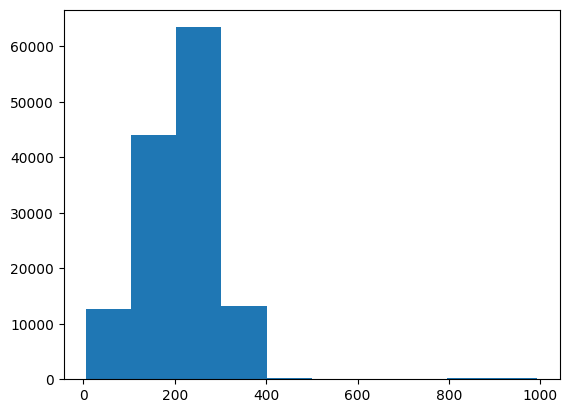

In [173]:
plt.hist(df_tweets['tweet_length_char'])

In [174]:
X = df[numerical_features]

In [175]:
Y = df['majority_target']

### Prepare data

In [176]:
# Instantiate SelectKBest with ANOVA F-value as the scoring function
def select_k_best_x(X, Y, k):
    select_k_best = SelectKBest(k=k)
    select_k_best.fit(X, Y)
    X_selected = select_k_best.transform(X)
    selected_features = X.columns[select_k_best.get_support()]
    return selected_features

In [177]:
def plot_training_history(history, title):
    metrics = ['loss', 'accuracy']
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for idx, metric in enumerate(metrics):
        axes[idx].plot(history.history[metric], label='Train')
        axes[idx].plot(history.history[f'val_{metric}'], label='Validation')
        axes[idx].set_title(f'{title} - {metric.capitalize()}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

In [178]:
def prepare_data(df, selected_features, include_text=False):
    # Prepare numerical features
    X_num = df[selected_features].values    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_num)
    
    if include_text:
        # Prepare text features
        tokenizer = Tokenizer(num_words=10000)
        tokenizer.fit_on_texts(df['tweet'])
        X_text = tokenizer.texts_to_sequences(df['tweet'])
        X_text_padded = pad_sequences(X_text, maxlen=100)
        
        return X_scaled, X_text_padded, df['majority_target'].values, tokenizer
    
    return X_scaled, df['majority_target'].values

### Evaluate model

In [179]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [180]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model and return comprehensive metrics"""
    metrics = model.evaluate(X_test, y_test, verbose=0)
    metrics_dict = dict(zip(model.metrics_names, metrics))
    
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred_classes = (y_pred_proba > 0.5).astype(int)
    
    # Calculate additional metrics
    additional_metrics = {
        'auc_score': roc_auc_score(y_test, y_pred_proba),
        'precision': precision_score(y_test, y_pred_classes),
        'recall': recall_score(y_test, y_pred_classes),
        'f1': f1_score(y_test, y_pred_classes),
        'accuracy': accuracy_score(y_test, y_pred_classes)
    }
    
    # Print metrics
    print("\nModel Performance Metrics:")
    print(f"Test Loss: {metrics_dict['loss']:.4f}")
    print(f"Test Accuracy: {additional_metrics['accuracy']:.4f}")
    print(f"Test AUC (sklearn): {additional_metrics['auc_score']:.4f}")
    print(f"Test Precision: {additional_metrics['precision']:.4f}")
    print(f"Test Recall: {additional_metrics['recall']:.4f}")
    print(f"Test F1 Score: {additional_metrics['f1']:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))
    
    return metrics_dict, additional_metrics

## Models

### CNN numerical

In [181]:
def cnn_model_v1(input_shape):
    """
    First version: Wide architecture with progressive layer sizes
    """
    model = Sequential([
        Dense(512, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy',
                AUC(name='auc'),
                Precision(name='precision'),
                Recall(name='recall')]
    )
    
    return model

In [182]:
def cnn_model_v2(input_shape):
    """
    Second version: Deeper architecture with residual-like connections
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy',
                AUC(name='auc'),
                Precision(name='precision'),
                Recall(name='recall')]
    )
    
    return model

### CNN numerical + text

In [230]:
def cnn_model_v3(max_words, max_len, num_features):
    # Text input branch
    text_input = Input(shape=(max_len,))
    embedding = Embedding(max_words, max_len)(text_input)  # Reduced embedding size

    # Convolution layers with multiple kernel sizes
    conv1 = Conv1D(64, 5, activation='relu', padding='same')(embedding)
    pool1 = MaxPooling1D(2)(conv1)

    conv2 = Conv1D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling1D(2)(conv2)

    conv3 = Conv1D(256, 3, activation='relu', padding='same')(pool2)
    pool3 = MaxPooling1D(2)(conv3)

    # Global pooling
    pooled = GlobalAveragePooling1D()(pool3)

    # Numerical features branch
    numerical_input = Input(shape=(num_features,))
    numerical_dense = Dense(128, activation='relu')(numerical_input)
    numerical_drop = Dropout(0.3)(numerical_dense)

    # Merge branches
    merged = Concatenate()([pooled, numerical_drop])
    dense1 = Dense(256, activation='relu')(merged)
    dropout1 = Dropout(0.4)(dense1)
    dense2 = Dense(128, activation='relu')(dropout1)
    output = Dense(1, activation='sigmoid')(dense2)

    model = Model(inputs=[numerical_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [251]:
def cnn_model_v3_lstm(max_words, max_len, num_features):
    # Text input branch
    text_input = Input(shape=(max_len,))
    embedding = Embedding(max_words, max_len)(text_input)  # Reduced embedding size

    # Convolution layer with multiple kernel sizes
    conv1 = Conv1D(64, 5, activation='relu', padding='same')(embedding)  # Single kernel size
    pool1 = MaxPooling1D(2)(conv1)

    # Bidirectional LSTM layer
    lstm = Bidirectional(LSTM(64, return_sequences=True))(pool1)  # Reduced LSTM units

    # Global pooling
    pooled = GlobalAveragePooling1D()(lstm)

    # Numerical features branch
    numerical_input = Input(shape=(num_features,))
    numerical_dense = Dense(128, activation='relu')(numerical_input)  # Reduced size
    numerical_drop = Dropout(0.3)(numerical_dense)

    # Merge branches
    merged = Concatenate()([pooled, numerical_drop])
    dense1 = Dense(256, activation='relu')(merged)
    dropout1 = Dropout(0.4)(dense1)
    output = Dense(1, activation='sigmoid')(dropout1)

    model = Model(inputs=[numerical_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [252]:
def cnn_model_v3_lstm_improved(max_words, max_len, num_features):
     # Text input branch
    text_input = Input(shape=(max_len,))
    embedding = Embedding(max_words, 200)(text_input)
    
    # Single convolution layer
    conv1 = Conv1D(128, 5, activation='relu', padding='same')(embedding)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(2)(bn1)
    
    # Additional convolution layers
    conv2 = Conv1D(256, 5, activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(2)(bn2)
    
    # Bidirectional LSTM layer
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool2)
    
    # Both global average and max pooling
    avg_pool = GlobalAveragePooling1D()(lstm)
    max_pool = GlobalMaxPooling1D()(lstm)
    concat2 = Concatenate()([avg_pool, max_pool])
    
    # Numerical features branch
    numerical_input = Input(shape=(num_features,))
    numerical_dense1 = Dense(256, activation='relu')(numerical_input)
    numerical_bn1 = BatchNormalization()(numerical_dense1)
    numerical_drop1 = Dropout(0.4)(numerical_bn1)
    numerical_dense2 = Dense(128, activation='relu')(numerical_drop1)
    numerical_bn2 = BatchNormalization()(numerical_dense2)
    
    # Merge branches
    merged = Concatenate()([concat2, numerical_bn2])
    dense1 = Dense(512, activation='relu')(merged)
    bn3 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.5)(bn3)
    dense2 = Dense(256, activation='relu')(dropout1)
    bn4 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.4)(bn4)
    dense3 = Dense(128, activation='relu')(dropout2)
    bn5 = BatchNormalization()(dense3)
    dropout3 = Dropout(0.3)(bn5)
    output = Dense(1, activation='sigmoid')(dropout3)
    
    model = Model(inputs=[numerical_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### CNN text only

In [199]:
def cnn_model_text_only(max_words, max_len):
    # Text input branch
    text_input = Input(shape=(max_len,))
    embedding = Embedding(max_words, 200)(text_input)
    
    # Single convolution layer
    conv1 = Conv1D(128, 5, activation='relu', padding='same')(embedding)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(2)(bn1)
    
    # Additional convolution layers
    conv2 = Conv1D(256, 5, activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(2)(bn2)
    
    # Global average pooling
    avg_pool = GlobalAveragePooling1D()(pool2)
    
    # Dense layers
    dense1 = Dense(256, activation='relu')(avg_pool)
    dropout1 = Dropout(0.5)(dense1)
    output = Dense(1, activation='sigmoid')(dropout1)  # Binary classification

    # Create the model
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [187]:
def cnn_model_text_only(max_words, max_len):
    # Text input branch
    text_input = Input(shape=(max_len,))
    embedding = Embedding(max_words, 200)(text_input)
    
    # Multiple parallel convolution layers with different kernel sizes
    conv1_3 = Conv1D(128, 3, activation='relu', padding='same')(embedding)
    conv1_5 = Conv1D(128, 5, activation='relu', padding='same')(embedding)
    conv1_7 = Conv1D(128, 7, activation='relu', padding='same')(embedding)
    
    # Batch normalization and pooling for each branch
    bn1_3 = BatchNormalization()(conv1_3)
    bn1_5 = BatchNormalization()(conv1_5)
    bn1_7 = BatchNormalization()(conv1_7)
    
    pool1_3 = MaxPooling1D(2)(bn1_3)
    pool1_5 = MaxPooling1D(2)(bn1_5)
    pool1_7 = MaxPooling1D(2)(bn1_7)
    
    # Concatenate branches
    concat1 = Concatenate()([pool1_3, pool1_5, pool1_7])
    
    # Additional convolution layers
    conv2 = Conv1D(256, 5, activation='relu')(concat1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(2)(bn2)
    
    # Global average pooling
    avg_pool = GlobalAveragePooling1D()(pool2)
    
    # Dense layers
    dense1 = Dense(256, activation='relu')(avg_pool)
    dropout1 = Dropout(0.5)(dense1)
    output = Dense(1, activation='sigmoid')(dropout1)  # Binary classification

    # Create the model
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [200]:
def cnn_model_text_only_lstm(max_words, max_len):
    # Text input branch
    text_input = Input(shape=(max_len,))
    embedding = Embedding(max_words, 200)(text_input)
    
    # Single convolution layer
    conv1 = Conv1D(128, 5, activation='relu', padding='same')(embedding)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(2)(bn1)
    
    # Additional convolution layers
    conv2 = Conv1D(256, 5, activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(2)(bn2)
    
    # Bidirectional LSTM layer
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool2)
    
    # Global average pooling
    avg_pool = GlobalAveragePooling1D()(lstm)
    
    # Dense layers
    dense1 = Dense(256, activation='relu')(avg_pool)
    dropout1 = Dropout(0.5)(dense1)
    output = Dense(1, activation='sigmoid')(dropout1)  # Binary classification

    # Create the model
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


### CNN hyperparameter tuning

In [ ]:
def build_tunable_model(hp):
    # Text input branch
    text_input = Input(shape=(max_len,))
    embedding_dim = hp.Int('embedding_dim', min_value=100, max_value=300, step=50)
    embedding = Embedding(max_words, embedding_dim)(text_input)
    
    # Multiple parallel convolution layers
    conv_filters = hp.Int('conv_filters', min_value=64, max_value=256, step=64)
    
    conv1_3 = Conv1D(conv_filters, 3, activation='relu', padding='same')(embedding)
    conv1_5 = Conv1D(conv_filters, 5, activation='relu', padding='same')(embedding)
    conv1_7 = Conv1D(conv_filters, 7, activation='relu', padding='same')(embedding)
    
    pool1_3 = MaxPooling1D(2)(conv1_3)
    pool1_5 = MaxPooling1D(2)(conv1_5)
    pool1_7 = MaxPooling1D(2)(conv1_7)
    
    concat1 = Concatenate()([pool1_3, pool1_5, pool1_7])
    
    # Additional convolution layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        concat1 = Conv1D(
            hp.Int(f'conv_{i}_units', min_value=128, max_value=512, step=128),
            5, activation='relu')(concat1)
        concat1 = BatchNormalization()(concat1)
        concat1 = MaxPooling1D(2)(concat1)
    
    # Optional LSTM layer
    if hp.Boolean('use_lstm'):
        concat1 = Bidirectional(LSTM(hp.Int('lstm_units', min_value=64, max_value=256, step=64),
                                   return_sequences=True))(concat1)
    
    # Pooling
    avg_pool = GlobalAveragePooling1D()(concat1)
    max_pool = GlobalMaxPooling1D()(concat1)
    concat2 = Concatenate()([avg_pool, max_pool])
    
    # Numerical features branch
    numerical_input = Input(shape=(num_features,))
    numerical = numerical_input
    
    for i in range(hp.Int('num_numerical_layers', 1, 3)):
        numerical = Dense(hp.Int(f'numerical_dense_{i}_units', min_value=64, max_value=256, step=64),
                        activation='relu')(numerical)
        numerical = BatchNormalization()(numerical)
        numerical = Dropout(hp.Float(f'numerical_dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(numerical)
    
    # Merge branches
    merged = Concatenate()([concat2, numerical])
    
    # Final dense layers
    for i in range(hp.Int('num_dense_layers', 1, 4)):
        merged = Dense(hp.Int(f'dense_{i}_units', min_value=64, max_value=512, step=64),
                      activation='relu')(merged)
        merged = BatchNormalization()(merged)
        merged = Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(merged)
    
    output = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[text_input, numerical_input], outputs=output)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## Train models

In [243]:
def train_model_baseline(X, y, model_version='v1', epochs=100, batch_size=32):
    # Handle text and numerical data for v3
    if model_version in ['v3', 'v3_lstm', 'v3_lstm_improved']:
        # Assuming X is a tuple (X_num, X_text)
        X_num, X_text = X
        X_train_num, X_test_num, X_train_text, X_test_text, y_train, y_test = train_test_split(
            X_num, X_text, y, test_size=0.2, random_state=42, stratify=y
        )
        X_train = [X_train_num, X_train_text]
        X_test = [X_test_num, X_test_text]
    elif model_version in ['text_only', 'text_only_lstm']:
        # Handle case for text-only models
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    else:
        # Handle general case for v1 and v2 where X is single input
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    
    # Create model based on version
    model_mapping = {
    'v1': cnn_model_v1,
    'v2': cnn_model_v2,
    'v3': cnn_model_v3,
    'v3_lstm': cnn_model_v3_lstm,
    'v3_lstm_improved': cnn_model_v3_lstm_improved,
    'text_only': cnn_model_text_only,
    'text_only_lstm': cnn_model_text_only_lstm,
    }

    # Get the model creation function based on the model version
    model_function = model_mapping.get(model_version)

    if model_function:
        # Call the model creation function with appropriate parameters
        if model_version in ['v3', 'v3_parallel', 'v3_lstm', 'v3_lstm_improved']:
            model = model_function(max_words=10000, max_len=100, num_features=(X_num.shape[1],))
        elif model_version in ['text_only', 'text_only_lstm']:
            model = model_function(max_words=10000, max_len=100)
        else:
            model = model_function((X.shape[1],))
        
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1
    )
    
    # Evaluate model
    metrics_dict, additional_metrics = evaluate_model(model, X_test, y_test)
    
    return model, history, metrics_dict, additional_metrics

In [259]:
def train_model_improved(X, y, model_version='v1', epochs=100, batch_size=32):
    # Handle text and numerical data for v3
    if model_version in ['v3', 'v3_lstm', 'v3_lstm_improved']:
        # Assuming X is a tuple (X_num, X_text)
        X_num, X_text = X
        X_train_num, X_test_num, X_train_text, X_test_text, y_train, y_test = train_test_split(
            X_num, X_text, y, test_size=0.2, random_state=42, stratify=y
        )
        X_train = [X_train_num, X_train_text]
        X_test = [X_test_num, X_test_text]
    elif model_version in ['text_only', 'text_only_lstm']:
        # Handle case for text-only models
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    else:
        # Handle general case for v1 and v2 where X is single input
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    
    # Create model based on version
    model_mapping = {
    'v1': cnn_model_v1,
    'v2': cnn_model_v2,
    'v3': cnn_model_v3,
    'v3_lstm': cnn_model_v3_lstm,
    'v3_lstm_improved': cnn_model_v3_lstm_improved,
    'text_only': cnn_model_text_only,
    'text_only_lstm': cnn_model_text_only_lstm,
    }

    # Get the model creation function based on the model version
    model_function = model_mapping.get(model_version)

    if model_function:
        # Call the model creation function with appropriate parameters
        if model_version in ['v3', 'v3_lstm', 'v3_lstm_improved']:
            model = model_function(max_words=10000, max_len=100, num_features=X_num.shape[1])
        elif model_version in ['text_only', 'text_only_lstm']:
            model = model_function(max_words=10000, max_len=100)
        else:
            model = model_function((X.shape[1],))
    
    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=8,
            min_lr=0.00001,
            verbose=1
        )
    ]
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    metrics_dict, additional_metrics = evaluate_model(model, X_test, y_test)
    
    return model, history, metrics_dict, additional_metrics

### Test models

In [212]:
X_scaled, X_text, y, tokenizer = prepare_data(df, select_k_best_x(X, Y, 30), include_text=True)

c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [227]:
X_text.shape

(134198, 100)

In [51]:
model_v1_baseline, history_v1_baseline, metrics_v1_baseline, additional_metrics_v1_baseline = train_model_baseline(X_scaled, y, epochs=50, model_version='v1') 

c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.5839 - auc: 0.6136 - loss: 0.7149 - precision: 0.5983 - recall: 0.5929 - val_accuracy: 0.6351 - val_auc: 0.6856 - val_loss: 0.6379 - val_precision: 0.6450 - val_recall: 0.6416
Epoch 2/50
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6302 - auc: 0.6783 - loss: 0.6429 - precision: 0.6431 - recall: 0.6222 - val_accuracy: 0.6343 - val_auc: 0.6889 - val_loss: 0.6395 - val_precision: 0.6728 - val_recall: 0.5588
Epoch 3/50
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6379 - auc: 0.6858 - loss: 0.6378 - precision: 0.6605 - recall: 0.6128 - val_accuracy: 0.6350 - val_auc: 0.6903 - val_loss: 0.6365 - val_precision: 0.6640 - val_recall: 0.5837
Epoch 4/50
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6402 - auc: 0.6915 - loss: 0.6344 - precision: 0.6623 - recall: 0.6193 - val_accuracy: 0.6434 - val_auc: 0.6984 - val_loss: 0.6293 - val_precision: 0.6559 - val_recall: 0.6415
Epoch 5/50
2684/2684

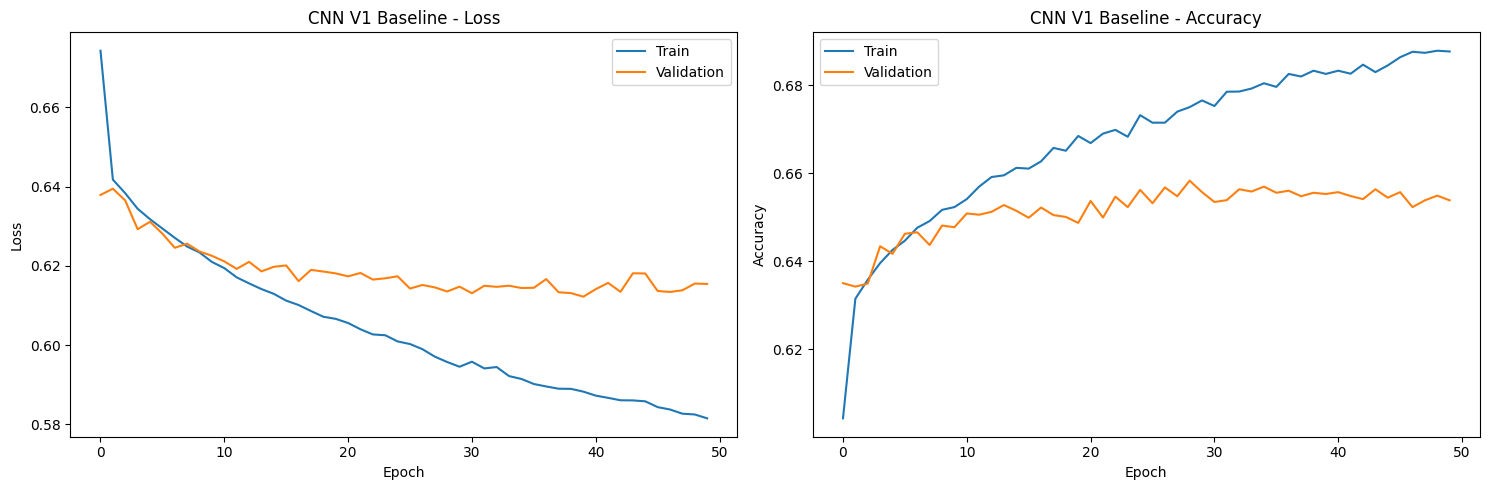

In [91]:
plot_training_history(history_v1_baseline, "CNN V1 Baseline")

In [90]:
save_model(model_v1_baseline, 'models/cnn_model_v1_baseline.keras')

In [93]:
model_v2_baseline, history_v2_baseline, metrics_v2_baseline, additional_metrics_v2_baseline = train_model_baseline(X_scaled, y, epochs=50, model_version='v2')

c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.5667 - auc: 0.5912 - loss: 0.7116 - precision: 0.5811 - recall: 0.5736 - val_accuracy: 0.6265 - val_auc: 0.6758 - val_loss: 0.6439 - val_precision: 0.6375 - val_recall: 0.6302
Epoch 2/50
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6235 - auc: 0.6677 - loss: 0.6492 - precision: 0.6367 - recall: 0.6259 - val_accuracy: 0.6359 - val_auc: 0.6861 - val_loss: 0.6382 - val_precision: 0.6540 - val_recall: 0.6159
Epoch 3/50
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6307 - auc: 0.6807 - loss: 0.6412 - precision: 0.6488 - recall: 0.6225 - val_accuracy: 0.6372 - val_auc: 0.6908 - val_loss: 0.6338 - val_precision: 0.6554 - val_recall: 0.6172
Epoch 4/50
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6353 - auc: 0.6843 - loss: 0.6389 - precision: 0.6522 - recall: 0.6240 - val_accuracy: 0.6433 - val_auc: 0.6961 - val_loss: 0.6310 - val_precision: 0.6601 - val_recall: 0.6279
Epoch 5/50
2684/2684

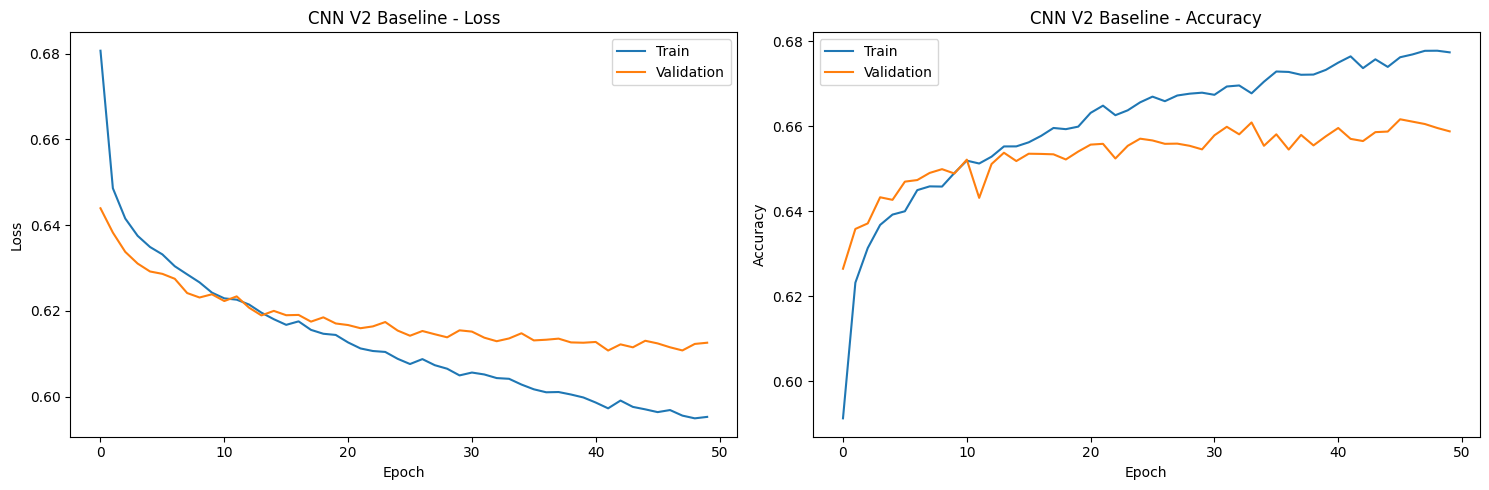

In [94]:
plot_training_history(history_v2_baseline, "CNN V2 Baseline")

In [213]:
save_model(model_v2_baseline, 'models/cnn_model_v2_baseline.keras')

In [ ]:
model_v1_improved, history_v1_improved, metrics_v1_improved, additional_metrics_v1_improved = train_model_improved(X_scaled, y, epochs=50, model_version='v1') 

In [ ]:
model_v2_improved, history_v2_improved, metrics_v2_improved, additional_metrics_v2_improved = train_model_improved(X_scaled, y, epochs=50, model_version='v2')

In [ ]:
save_model(model_v3_baseline, 'models/cnn_model_v3_baseline.keras')

In [254]:
model_v3_improved, history_v3_improved, metrics_v3_improved, additional_metrics_v3_improved = train_model_improved(
    X = [X_scaled, X_text],
    y=y, 
    model_version='v3_lstm_improved'
)

Epoch 1/100


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_517', 'keras_tensor_505']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2684/2684 ━━━━━━━━━━━━━━━━━━━━ 220s 79ms/step - accuracy: 0.7464 - loss: 0.5264 - val_accuracy: 0.9343 - val_loss: 0.2295 - learning_rate: 0.0010
Epoch 2/100
1739/2684 ━━━━━━━━━━━━━━━━━━━━ 1:04 68ms/step - accuracy: 0.9358 - loss: 0.2253

KeyboardInterrupt: 

## Mass test

Training model: v1


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5853 - auc: 0.6147 - loss: 0.7137 - precision: 0.5941 - recall: 0.5825 - val_accuracy: 0.6323 - val_auc: 0.6850 - val_loss: 0.6385 - val_precision: 0.6400 - val_recall: 0.6526 - learning_rate: 0.0010
Epoch 2/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6265 - auc: 0.6769 - loss: 0.6426 - precision: 0.6439 - recall: 0.6153 - val_accuracy: 0.6359 - val_auc: 0.6897 - val_loss: 0.6353 - val_precision: 0.6553 - val_recall: 0.6173 - learning_rate: 0.0010
Epoch 3/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6363 - auc: 0.6853 - loss: 0.6379 - precision: 0.6541 - recall: 0.6283 - val_accuracy: 0.6402 - val_auc: 0.6948 - val_loss: 0.6318 - val_precision: 0.6573 - val_recall: 0.6291 - learning_rate: 0.0010
Epoch 4/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6425 - auc: 0.6933 - loss: 0.6337 - precision: 0.6572 - recall: 0.6251 - val_accuracy: 0.6446 - val_auc: 0.6992 - val_loss:

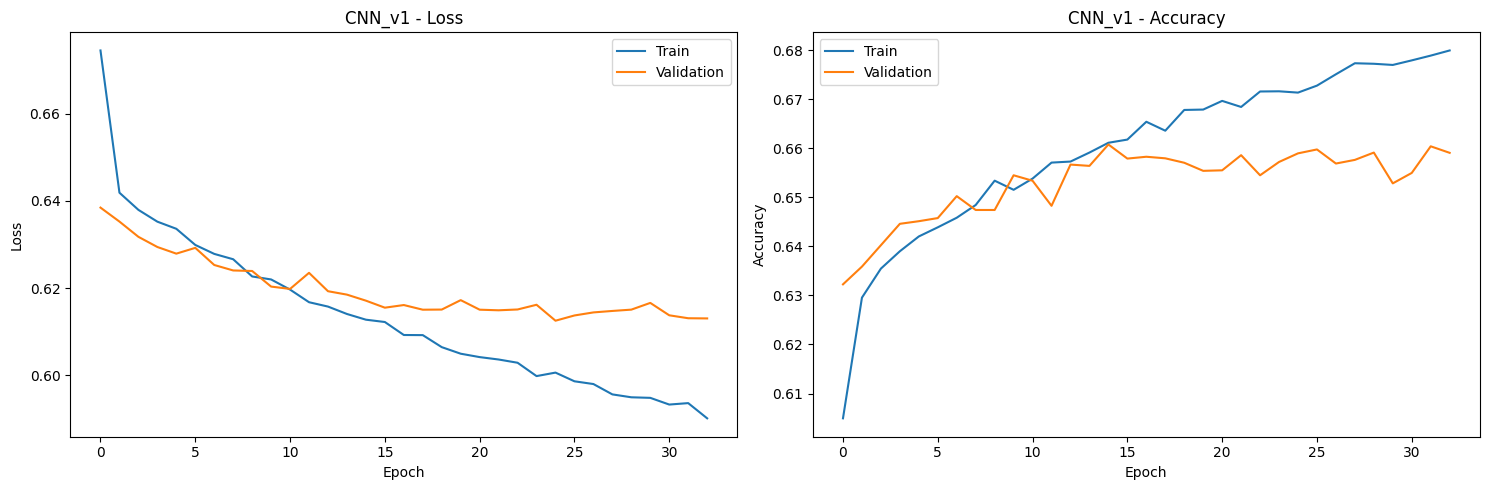

Training model: v2
Epoch 1/100


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5569 - auc: 0.5784 - loss: 0.7346 - precision: 0.5696 - recall: 0.5572 - val_accuracy: 0.6228 - val_auc: 0.6706 - val_loss: 0.6455 - val_precision: 0.6472 - val_recall: 0.5874 - learning_rate: 5.0000e-04
Epoch 2/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6147 - auc: 0.6587 - loss: 0.6538 - precision: 0.6312 - recall: 0.6078 - val_accuracy: 0.6318 - val_auc: 0.6839 - val_loss: 0.6389 - val_precision: 0.6473 - val_recall: 0.6256 - learning_rate: 5.0000e-04
Epoch 3/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6289 - auc: 0.6745 - loss: 0.6445 - precision: 0.6482 - recall: 0.6190 - val_accuracy: 0.6356 - val_auc: 0.6888 - val_loss: 0.6371 - val_precision: 0.6444 - val_recall: 0.6513 - learning_rate: 5.0000e-04
Epoch 4/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6353 - auc: 0.6842 - loss: 0.6393 - precision: 0.6489 - recall: 0.6306 - val_accuracy: 0.6360 - val_auc: 0.6944 - val_loss:

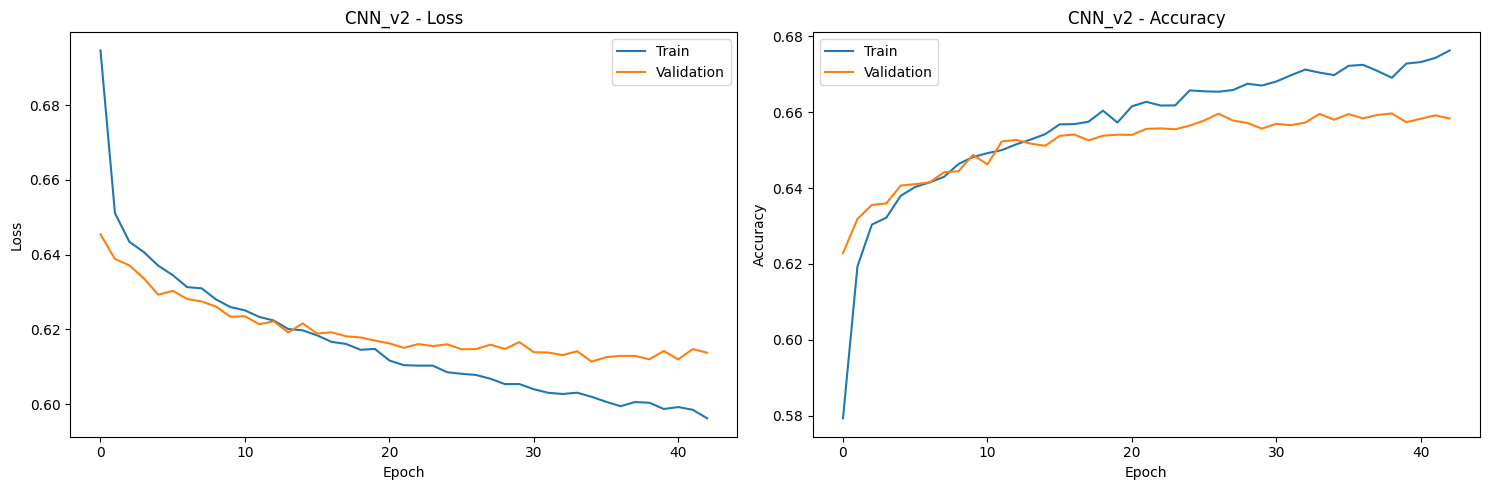

Training model: v3
Epoch 1/100


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_691', 'keras_tensor_682']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - accuracy: 0.8295 - loss: 0.3799 - val_accuracy: 0.9326 - val_loss: 0.2331 - learning_rate: 0.0010
Epoch 2/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.9465 - loss: 0.1968 - val_accuracy: 0.9326 - val_loss: 0.2321 - learning_rate: 0.0010
Epoch 3/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.9536 - loss: 0.1753 - val_accuracy: 0.9313 - val_loss: 0.2342 - learning_rate: 0.0010
Epoch 4/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.9616 - loss: 0.1441 - val_accuracy: 0.9219 - val_loss: 0.2596 - learning_rate: 0.0010
Epoch 5/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.9690 - loss: 0.1151 - val_accuracy: 0.9205 - val_loss: 0.2887 - learning_rate: 0.0010
Epoch 6/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.9762 - loss: 0.0898 - val_accuracy: 0.9148 - val_loss: 0.3812 - learning_rate: 0.0010
Epoch 7/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0

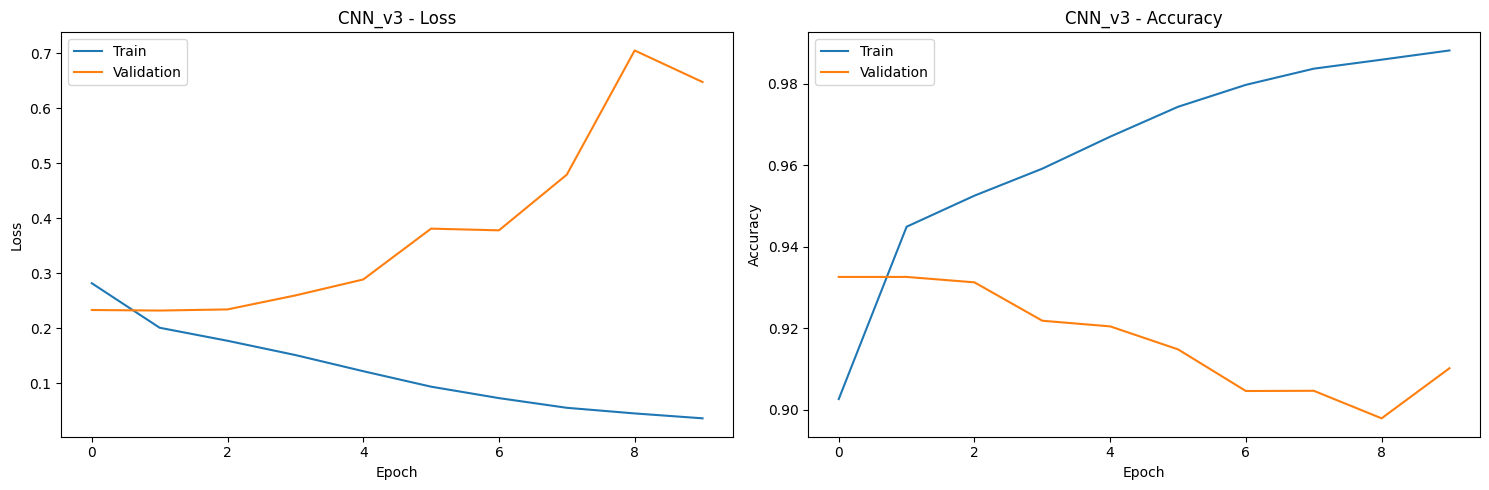

Training model: v3_lstm
Epoch 1/100


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_705', 'keras_tensor_699']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 78s 32ms/step - accuracy: 0.8528 - loss: 0.3483 - val_accuracy: 0.9337 - val_loss: 0.2332 - learning_rate: 0.0010
Epoch 2/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.9458 - loss: 0.1994 - val_accuracy: 0.9333 - val_loss: 0.2343 - learning_rate: 0.0010
Epoch 3/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.9535 - loss: 0.1797 - val_accuracy: 0.9300 - val_loss: 0.2449 - learning_rate: 0.0010
Epoch 4/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.9592 - loss: 0.1603 - val_accuracy: 0.9243 - val_loss: 0.2570 - learning_rate: 0.0010
Epoch 5/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 77s 33ms/step - accuracy: 0.9645 - loss: 0.1394 - val_accuracy: 0.9239 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 6/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 77s 33ms/step - accuracy: 0.9700 - loss: 0.1150 - val_accuracy: 0.9193 - val_loss: 0.3124 - learning_rate: 0.0010
Epoch 7/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0

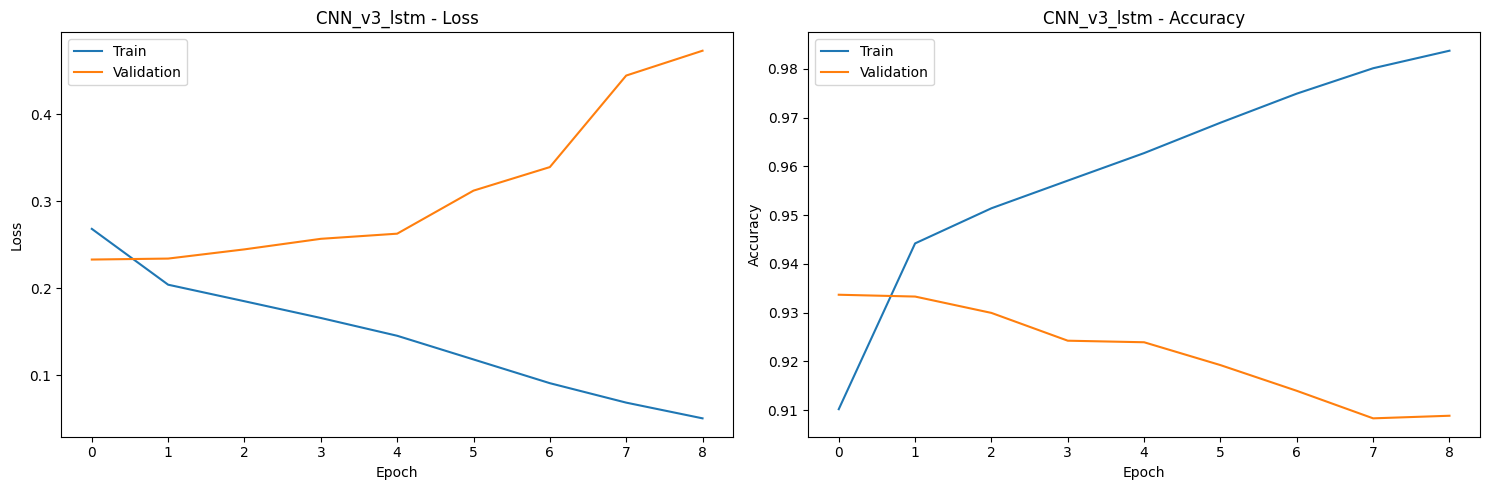

Training model: v3_lstm_improved
Epoch 1/100


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_724', 'keras_tensor_712']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 153s 62ms/step - accuracy: 0.7428 - loss: 0.5189 - val_accuracy: 0.9335 - val_loss: 0.2312 - learning_rate: 0.0010
Epoch 2/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 148s 63ms/step - accuracy: 0.9356 - loss: 0.2212 - val_accuracy: 0.9321 - val_loss: 0.2327 - learning_rate: 0.0010
Epoch 3/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 159s 68ms/step - accuracy: 0.9438 - loss: 0.2001 - val_accuracy: 0.9312 - val_loss: 0.2435 - learning_rate: 0.0010
Epoch 4/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 171s 73ms/step - accuracy: 0.9516 - loss: 0.1781 - val_accuracy: 0.9319 - val_loss: 0.2328 - learning_rate: 0.0010
Epoch 5/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 175s 75ms/step - accuracy: 0.9582 - loss: 0.1573 - val_accuracy: 0.8943 - val_loss: 0.3415 - learning_rate: 0.0010
Epoch 6/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 175s 75ms/step - accuracy: 0.9647 - loss: 0.1341 - val_accuracy: 0.9228 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 7/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 175s 75ms/step - accu

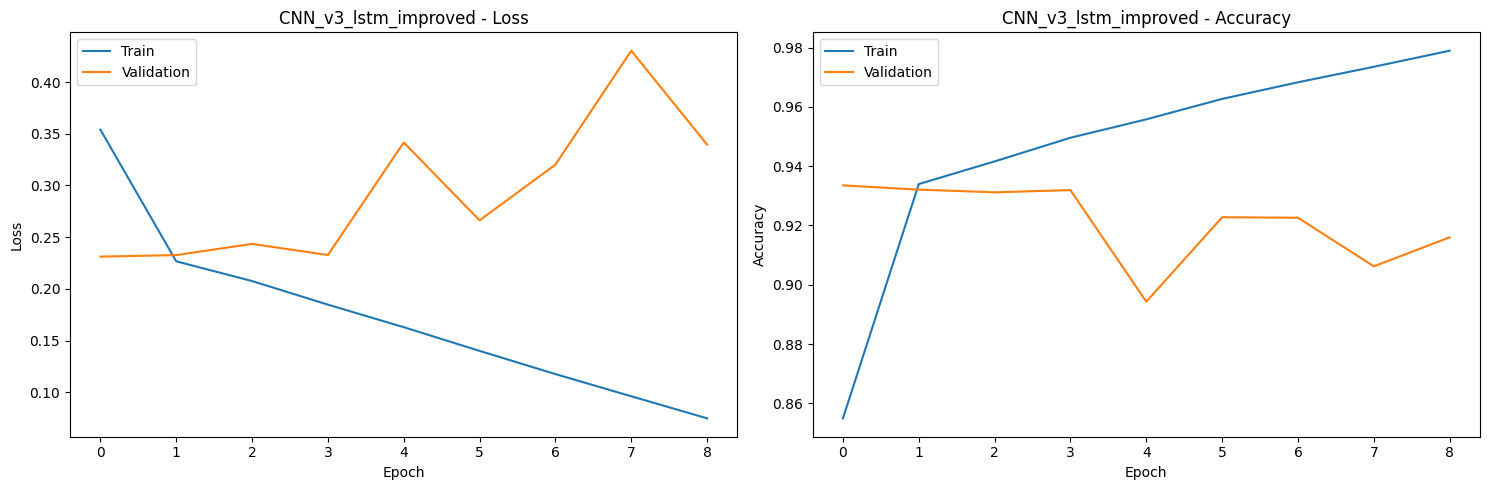

Training model: text_only
Epoch 1/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 99s 41ms/step - accuracy: 0.8701 - loss: 0.3377 - val_accuracy: 0.9300 - val_loss: 0.2419 - learning_rate: 0.0010
Epoch 2/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 95s 41ms/step - accuracy: 0.9418 - loss: 0.2053 - val_accuracy: 0.9310 - val_loss: 0.2650 - learning_rate: 0.0010
Epoch 3/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.9533 - loss: 0.1646 - val_accuracy: 0.9316 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 4/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 96s 41ms/step - accuracy: 0.9632 - loss: 0.1204 - val_accuracy: 0.9195 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 5/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.9734 - loss: 0.0803 - val_accuracy: 0.9227 - val_loss: 0.4047 - learning_rate: 0.0010
Epoch 6/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 96s 41ms/step - accuracy: 0.9805 - loss: 0.0585 - val_accuracy: 0.9225 - val_loss: 0.4755 - learning_rate: 0.0010
Epoch 7/100
2349/2349 ━━━━━━━━━━

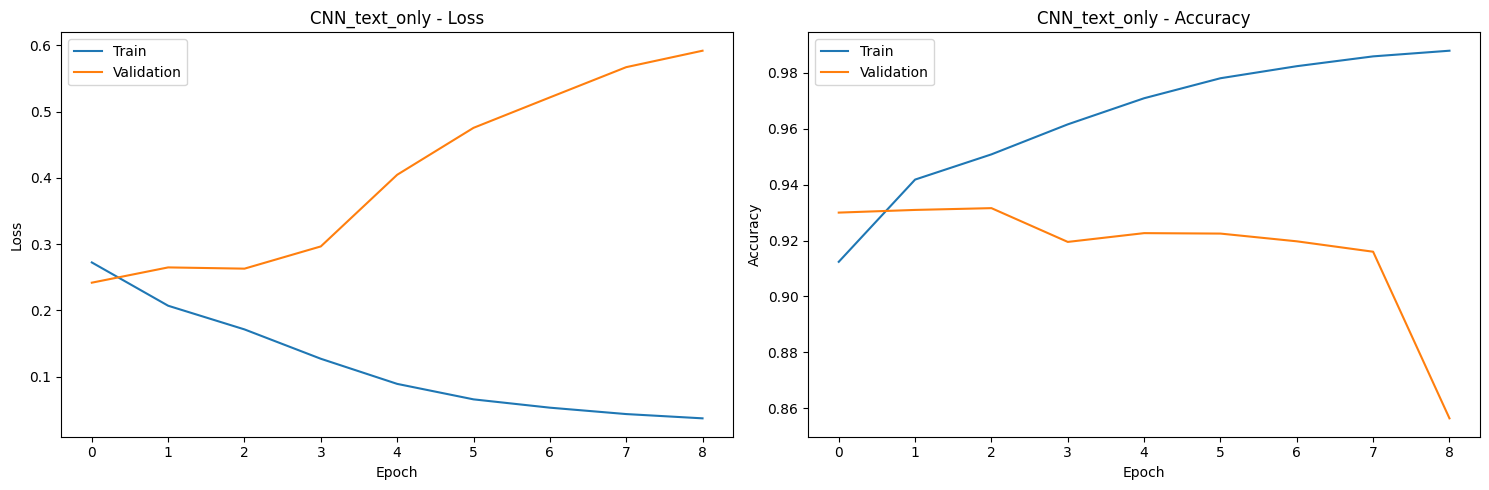

Training model: text_only_lstm
Epoch 1/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 185s 75ms/step - accuracy: 0.8594 - loss: 0.3431 - val_accuracy: 0.9312 - val_loss: 0.2346 - learning_rate: 0.0010
Epoch 2/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 180s 77ms/step - accuracy: 0.9422 - loss: 0.2090 - val_accuracy: 0.9304 - val_loss: 0.2370 - learning_rate: 0.0010
Epoch 3/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 177s 75ms/step - accuracy: 0.9503 - loss: 0.1863 - val_accuracy: 0.9195 - val_loss: 0.2581 - learning_rate: 0.0010
Epoch 4/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 178s 76ms/step - accuracy: 0.9553 - loss: 0.1661 - val_accuracy: 0.9244 - val_loss: 0.2510 - learning_rate: 0.0010
Epoch 5/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 180s 77ms/step - accuracy: 0.9627 - loss: 0.1405 - val_accuracy: 0.9244 - val_loss: 0.2913 - learning_rate: 0.0010
Epoch 6/100
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 181s 77ms/step - accuracy: 0.9690 - loss: 0.1122 - val_accuracy: 0.9218 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 7/100
2349/2349

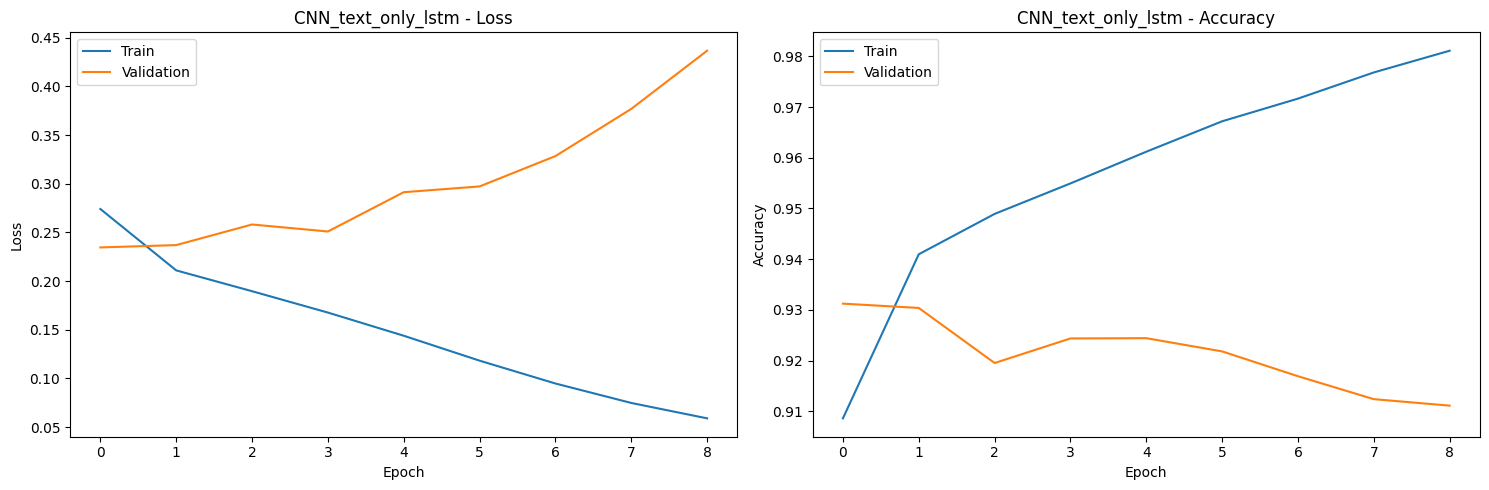

In [258]:
#Latest
model_versions = ['v1', 'v2', 'v3', 'v3_lstm', 'v3_lstm_improved', 'text_only', 'text_only_lstm']

# Initialize an empty list to collect metrics
metrics_list = []

# Loop through each model version
for model_version in model_versions:
    print(f"Training model: {model_version}")
    
    # Train the model
    if model_version in ['v3', 'v3_lstm', 'v3_lstm_improved']:
        # Assuming you have numerical data for these models
        model, history, metrics_dict, additional_metrics = train_model_improved(
            X=[X_scaled, X_text],
            y=y,
            model_version=model_version,
            epochs=100,
            batch_size=32
        )
    elif model_version in ['text_only', 'text_only_lstm']:
        # Text-only models
        model, history, metrics_dict, additional_metrics = train_model_improved(
            X=X_text,
            y=y,
            model_version=model_version,
            epochs=100,
            batch_size=32
        )
    else:
        # Other models (v1, v2)
        model, history, metrics_dict, additional_metrics = train_model_improved(
            X=X_scaled,
            y=y,
            model_version=model_version,
            epochs=100,
            batch_size=32
        )
    
    # Save the model
    model_name = f'models/cnn_model_{model_version}_baseline.keras'
    save_model(model, model_name)
    
    # Append metrics to the list
    metrics_list.append({
        'version': model_version,
        'loss': metrics_dict['loss'],
        'accuracy': additional_metrics['accuracy'],
        'auc_score': additional_metrics['auc_score'],
        'precision': additional_metrics['precision'],
        'recall': additional_metrics['recall'],
        'f1': additional_metrics['f1']
    })

    plot_training_history(history, f'CNN_{model_version}')

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# Optionally, save the DataFrame to a CSV file
metrics_df.to_csv('model_metrics.csv', index=False)


Training model: v1


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.5836 - auc: 0.6156 - loss: 0.7038 - precision: 0.5957 - recall: 0.5929 - val_accuracy: 0.6306 - val_auc: 0.6809 - val_loss: 0.6411 - val_precision: 0.6388 - val_recall: 0.6441 - learning_rate: 0.0010
Epoch 2/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6312 - auc: 0.6798 - loss: 0.6414 - precision: 0.6484 - recall: 0.6263 - val_accuracy: 0.6348 - val_auc: 0.6896 - val_loss: 0.6347 - val_precision: 0.6643 - val_recall: 0.5824 - learning_rate: 0.0010
Epoch 3/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - accuracy: 0.6344 - auc: 0.6846 - loss: 0.6390 - precision: 0.6520 - recall: 0.6205 - val_accuracy: 0.6357 - val_auc: 0.6904 - val_loss: 0.6354 - val_precision: 0.6769 - val_recall: 0.5544 - learning_rate: 0.0010
Epoch 4/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6398 - auc: 0.6901 - loss: 0.6352 - precision: 0.6637 - recall: 0.6127 - val_accuracy: 0.6433 - val_auc: 0.6989 - val_los

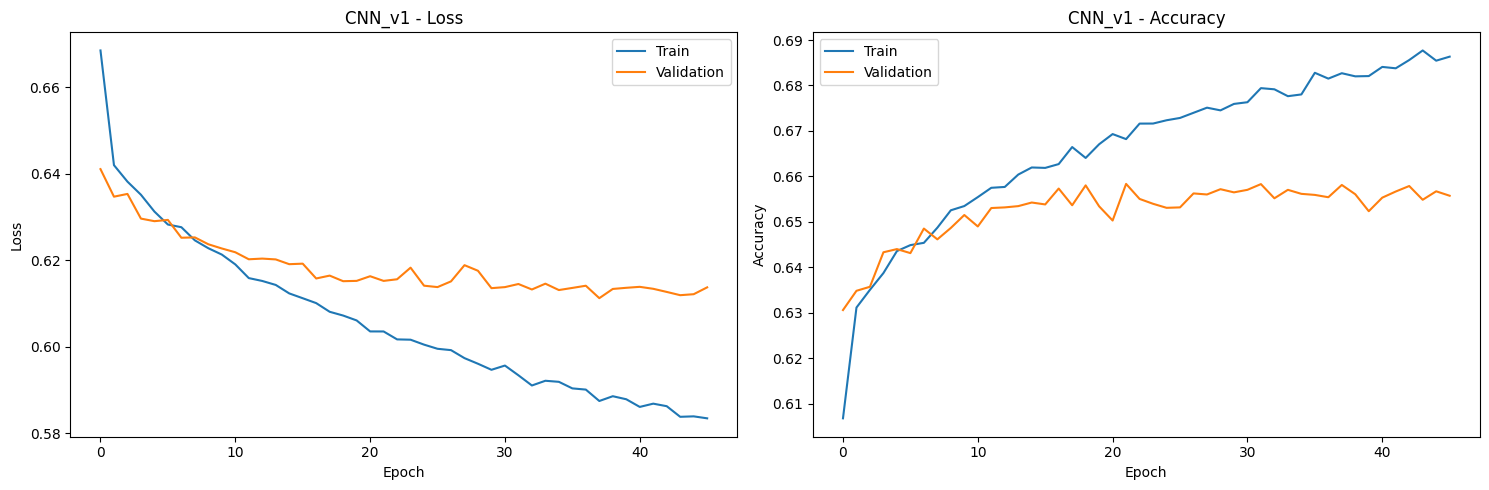

Training model: v2


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.5622 - auc: 0.5863 - loss: 0.7147 - precision: 0.5742 - recall: 0.5765 - val_accuracy: 0.6225 - val_auc: 0.6733 - val_loss: 0.6444 - val_precision: 0.6312 - val_recall: 0.6351 - learning_rate: 5.0000e-04
Epoch 2/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6157 - auc: 0.6595 - loss: 0.6534 - precision: 0.6287 - recall: 0.6159 - val_accuracy: 0.6330 - val_auc: 0.6840 - val_loss: 0.6379 - val_precision: 0.6524 - val_recall: 0.6090 - learning_rate: 5.0000e-04
Epoch 3/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6305 - auc: 0.6771 - loss: 0.6432 - precision: 0.6490 - recall: 0.6206 - val_accuracy: 0.6406 - val_auc: 0.6930 - val_loss: 0.6330 - val_precision: 0.6499 - val_recall: 0.6488 - learning_rate: 5.0000e-04
Epoch 4/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6330 - auc: 0.6823 - loss: 0.6396 - precision: 0.6503 - recall: 0.6156 - val_accuracy: 0.6436 - val_auc: 0.6949

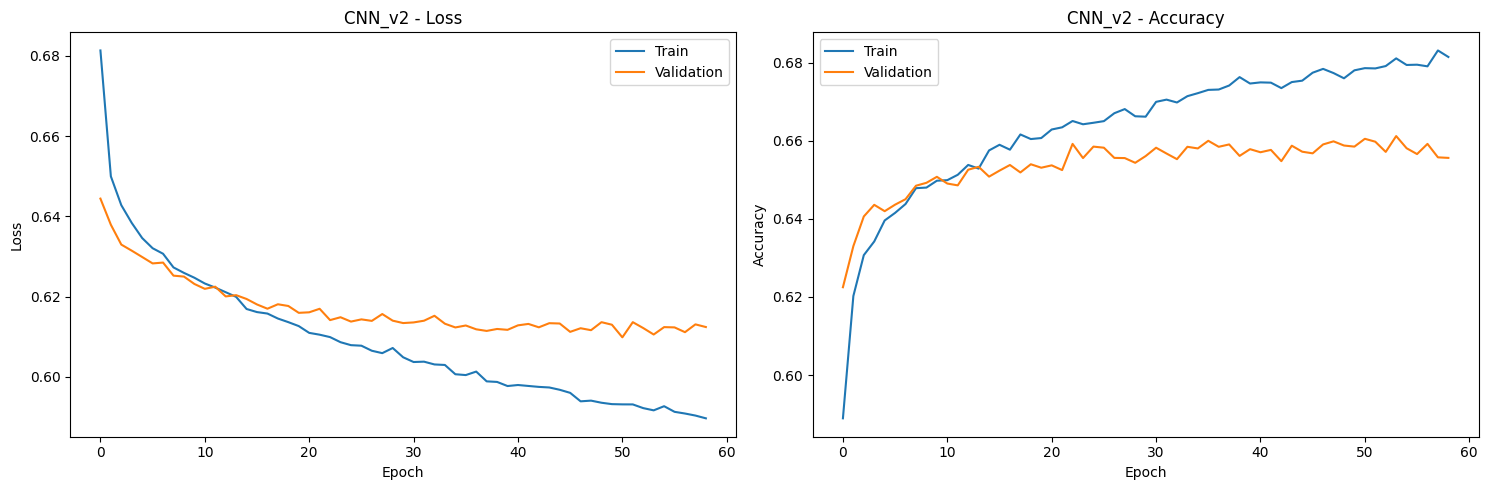

Training model: v3
Epoch 1/100


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_575', 'keras_tensor_566']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2684/2684 ━━━━━━━━━━━━━━━━━━━━ 71s 25ms/step - accuracy: 0.8340 - loss: 0.3801 - val_accuracy: 0.9367 - val_loss: 0.2232 - learning_rate: 0.0010
Epoch 2/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.9454 - loss: 0.2011 - val_accuracy: 0.9361 - val_loss: 0.2237 - learning_rate: 0.0010
Epoch 3/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 56s 21ms/step - accuracy: 0.9534 - loss: 0.1768 - val_accuracy: 0.9258 - val_loss: 0.2487 - learning_rate: 0.0010
Epoch 4/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 46s 17ms/step - accuracy: 0.9598 - loss: 0.1539 - val_accuracy: 0.9282 - val_loss: 0.2484 - learning_rate: 0.0010
Epoch 5/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 69s 26ms/step - accuracy: 0.9674 - loss: 0.1232 - val_accuracy: 0.9254 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 6/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 73s 27ms/step - accuracy: 0.9731 - loss: 0.0966 - val_accuracy: 0.9219 - val_loss: 0.3006 - learning_rate: 0.0010
Epoch 7/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - accuracy: 0

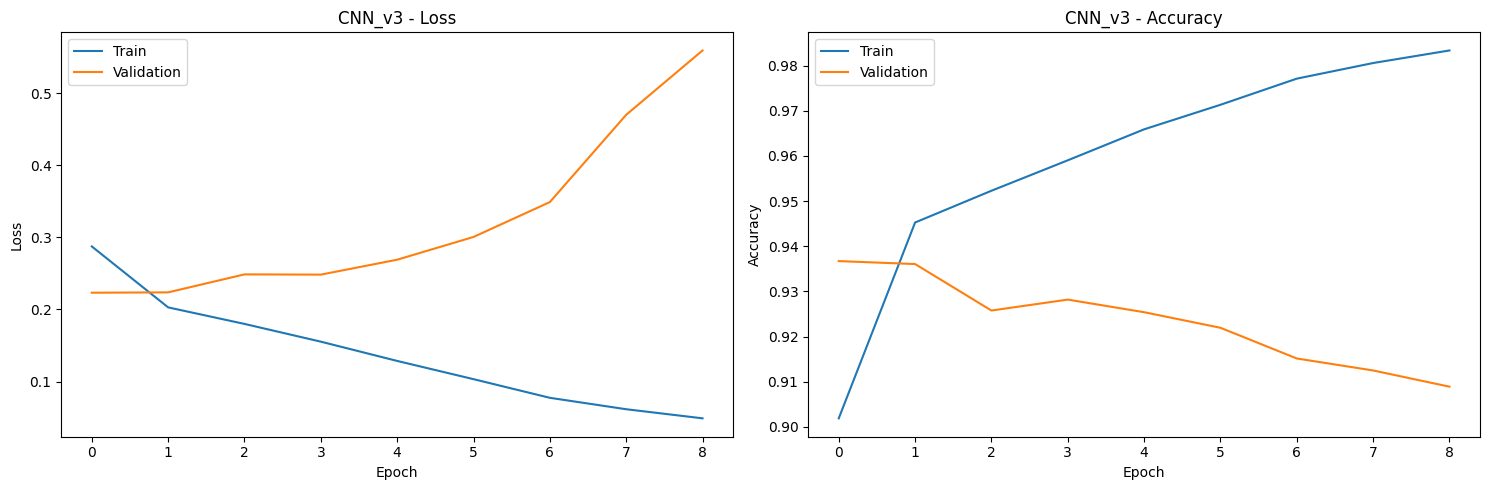

Training model: v3_lstm
Epoch 1/100


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_589', 'keras_tensor_583']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2684/2684 ━━━━━━━━━━━━━━━━━━━━ 84s 30ms/step - accuracy: 0.8578 - loss: 0.3415 - val_accuracy: 0.9346 - val_loss: 0.2257 - learning_rate: 0.0010
Epoch 2/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 75s 28ms/step - accuracy: 0.9444 - loss: 0.2058 - val_accuracy: 0.9372 - val_loss: 0.2203 - learning_rate: 0.0010
Epoch 3/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 79s 29ms/step - accuracy: 0.9505 - loss: 0.1878 - val_accuracy: 0.9302 - val_loss: 0.2351 - learning_rate: 0.0010
Epoch 4/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 76s 28ms/step - accuracy: 0.9576 - loss: 0.1628 - val_accuracy: 0.9321 - val_loss: 0.2326 - learning_rate: 0.0010
Epoch 5/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 76s 28ms/step - accuracy: 0.9641 - loss: 0.1353 - val_accuracy: 0.9286 - val_loss: 0.2543 - learning_rate: 0.0010
Epoch 6/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 76s 28ms/step - accuracy: 0.9688 - loss: 0.1080 - val_accuracy: 0.9121 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 7/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 74s 28ms/step - accuracy: 0

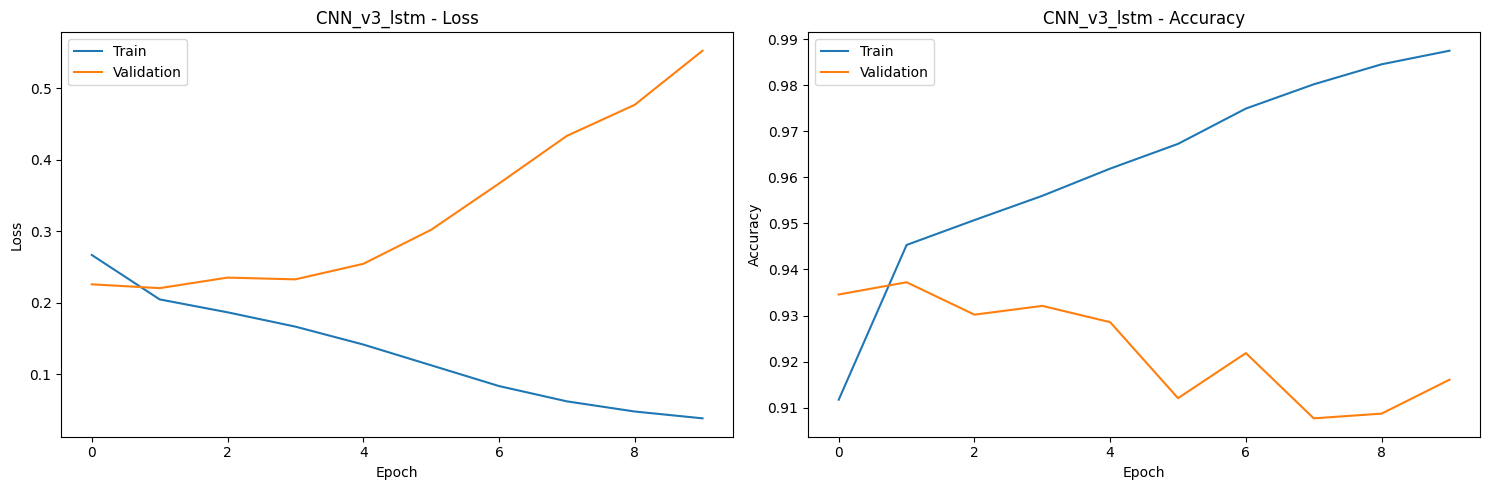

Training model: v3_lstm_improved
Epoch 1/100


c:\Users\madel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_608', 'keras_tensor_596']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2684/2684 ━━━━━━━━━━━━━━━━━━━━ 172s 62ms/step - accuracy: 0.7521 - loss: 0.5161 - val_accuracy: 0.9293 - val_loss: 0.2320 - learning_rate: 0.0010
Epoch 2/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 186s 69ms/step - accuracy: 0.9336 - loss: 0.2285 - val_accuracy: 0.9336 - val_loss: 0.2353 - learning_rate: 0.0010
Epoch 3/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 187s 70ms/step - accuracy: 0.9420 - loss: 0.2076 - val_accuracy: 0.9368 - val_loss: 0.2253 - learning_rate: 0.0010
Epoch 4/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 159s 59ms/step - accuracy: 0.9498 - loss: 0.1871 - val_accuracy: 0.9278 - val_loss: 0.2526 - learning_rate: 0.0010
Epoch 5/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 161s 60ms/step - accuracy: 0.9575 - loss: 0.1645 - val_accuracy: 0.9340 - val_loss: 0.2336 - learning_rate: 0.0010
Epoch 6/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 161s 60ms/step - accuracy: 0.9613 - loss: 0.1427 - val_accuracy: 0.9225 - val_loss: 0.2876 - learning_rate: 0.0010
Epoch 7/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 162s 60ms/step - accu

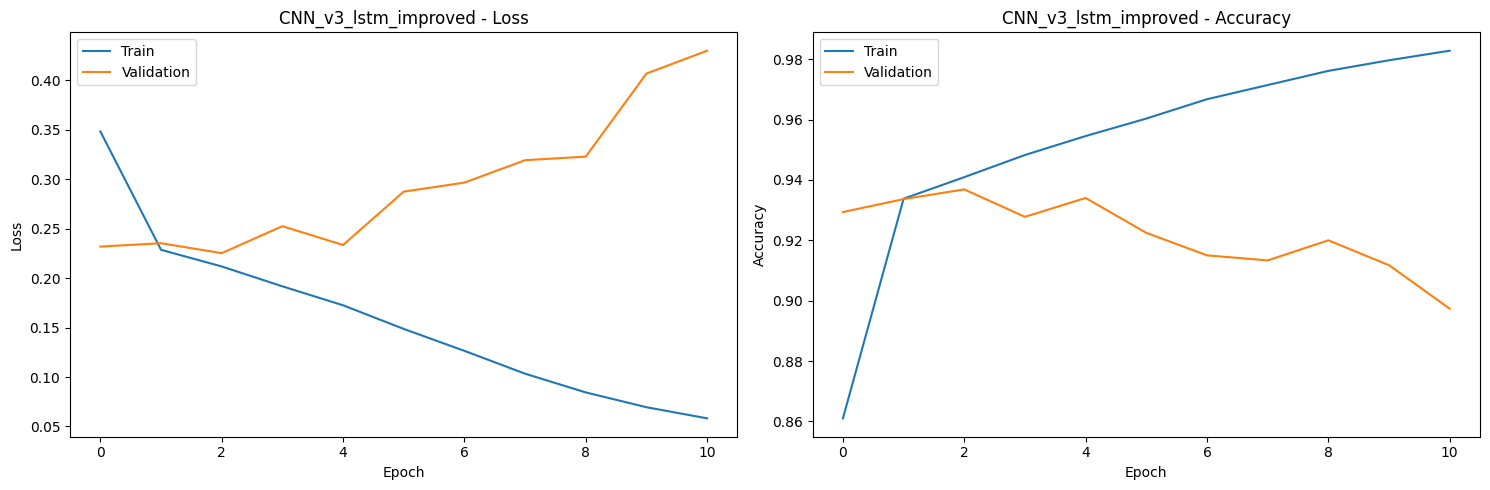

Training model: text_only
Epoch 1/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 85s 31ms/step - accuracy: 0.8784 - loss: 0.3262 - val_accuracy: 0.9369 - val_loss: 0.2240 - learning_rate: 0.0010
Epoch 2/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 84s 31ms/step - accuracy: 0.9433 - loss: 0.2065 - val_accuracy: 0.9357 - val_loss: 0.2243 - learning_rate: 0.0010
Epoch 3/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 85s 32ms/step - accuracy: 0.9527 - loss: 0.1697 - val_accuracy: 0.9348 - val_loss: 0.2347 - learning_rate: 0.0010
Epoch 4/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 85s 31ms/step - accuracy: 0.9620 - loss: 0.1238 - val_accuracy: 0.9270 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 5/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 84s 31ms/step - accuracy: 0.9726 - loss: 0.0831 - val_accuracy: 0.9274 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 6/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 100s 37ms/step - accuracy: 0.9795 - loss: 0.0593 - val_accuracy: 0.9182 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 7/100
2684/2684 ━━━━━━━━━

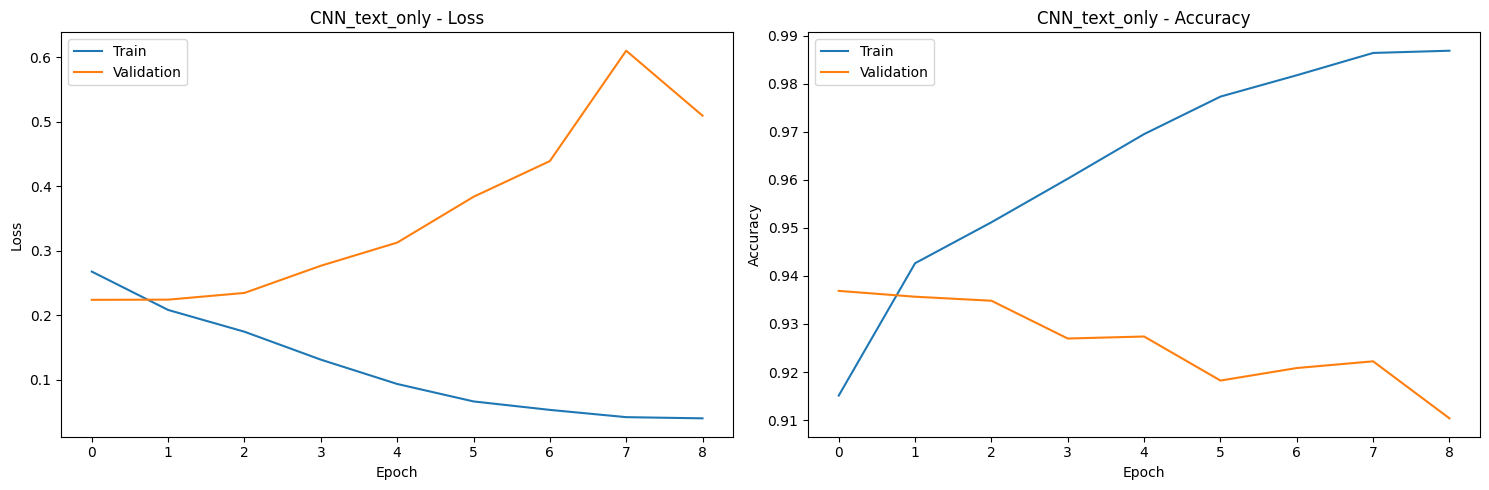

Training model: text_only_lstm
Epoch 1/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 152s 55ms/step - accuracy: 0.8659 - loss: 0.3364 - val_accuracy: 0.9337 - val_loss: 0.2322 - learning_rate: 0.0010
Epoch 2/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 148s 55ms/step - accuracy: 0.9416 - loss: 0.2115 - val_accuracy: 0.9346 - val_loss: 0.2278 - learning_rate: 0.0010
Epoch 3/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 148s 55ms/step - accuracy: 0.9503 - loss: 0.1860 - val_accuracy: 0.9327 - val_loss: 0.2278 - learning_rate: 0.0010
Epoch 4/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 146s 54ms/step - accuracy: 0.9551 - loss: 0.1686 - val_accuracy: 0.9321 - val_loss: 0.2290 - learning_rate: 0.0010
Epoch 5/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 144s 54ms/step - accuracy: 0.9606 - loss: 0.1473 - val_accuracy: 0.9278 - val_loss: 0.2489 - learning_rate: 0.0010
Epoch 6/100
2684/2684 ━━━━━━━━━━━━━━━━━━━━ 147s 55ms/step - accuracy: 0.9660 - loss: 0.1240 - val_accuracy: 0.9218 - val_loss: 0.3077 - learning_rate: 0.0010
Epoch 7/100
2684/2684

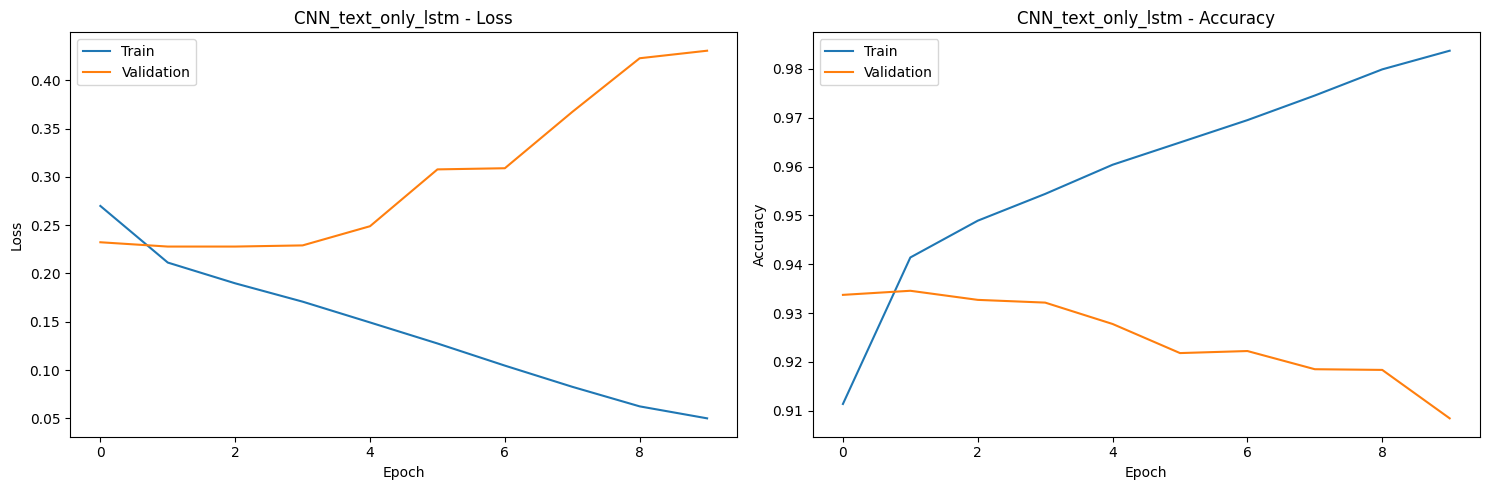

In [255]:
# Define the list of model versions
model_versions = ['v1', 'v2', 'v3', 'v3_lstm', 'v3_lstm_improved', 'text_only', 'text_only_lstm']

# Initialize an empty list to collect metrics
metrics_list = []

# Loop through each model version
for model_version in model_versions:
    print(f"Training model: {model_version}")
    
    # Train the model
    if model_version in ['v3', 'v3_lstm', 'v3_lstm_improved']:
        # Assuming you have numerical data for these models
        model, history, metrics_dict, additional_metrics = train_model_improved(
            X=[X_scaled, X_text],
            y=y,
            model_version=model_version,
            epochs=100,
            batch_size=32
        )
    elif model_version in ['text_only', 'text_only_lstm']:
        # Text-only models
        model, history, metrics_dict, additional_metrics = train_model_improved(
            X=X_text,
            y=y,
            model_version=model_version,
            epochs=100,
            batch_size=32
        )
    else:
        # Other models (v1, v2)
        model, history, metrics_dict, additional_metrics = train_model_improved(
            X=X_scaled,
            y=y,
            model_version=model_version,
            epochs=100,
            batch_size=32
        )
    
    # Save the model
    model_name = f'models/cnn_model_{model_version}_baseline.keras'
    save_model(model, model_name)
    
    # Append metrics to the list
    metrics_list.append({
        'version': model_version,
        'loss': metrics_dict['loss'],
        'accuracy': additional_metrics['accuracy'],
        'auc_score': additional_metrics['auc_score'],
        'precision': additional_metrics['precision'],
        'recall': additional_metrics['recall'],
        'f1': additional_metrics['f1']
    })

    plot_training_history(history, f'CNN_{model_version}')

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# Optionally, save the DataFrame to a CSV file
metrics_df.to_csv('model_metrics.csv', index=False)


In [256]:
metrics_df

,version,loss,accuracy,auc_score,precision,recall,f1
0,v1,0.608999,0.662332,0.726306,0.676431,0.657752,0.666961
1,v2,0.610322,0.661513,0.724983,0.680564,0.643618,0.661576
2,v3,0.223719,0.937072,0.953200,0.938759,0.938827,0.938793
3,v3_lstm,0.219138,0.938003,0.953592,0.934345,0.945858,0.940066
4,v3_lstm_improved,0.224361,0.937742,0.954451,0.934312,0.945350,0.939799
5,text_only,0.226752,0.936624,0.954203,0.932185,0.945495,0.938793
6,text_only_lstm,0.227272,0.935879,0.952745,0.944755,0.929622,0.937128
